In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI

# 1. 메시지 구성 (System + Human)
messages = [
    SystemMessage(content = '당신은 친절한 도우미 입니다.', name='System'),
    HumanMessage(content = '오늘 날씨가 어때?', name = 'User')
]
'''
1. 도구 사용을 위한 LLM 준비
'''
# 2. 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini",base_url="",api_key="",temperature = 0.7)

# 3. LLM 호출 및 응답 저장
ai_response = llm.invoke(messages)

# 4. 응답 내용 출력
print(ai_response.content)

제가 실시간 날씨 정보를 제공할 수는 없지만, 오늘 날씨를 확인하려면 기상청 웹사이트나 날씨 앱을 이용해 보시길 추천합니다. 어떤 지역의 날씨가 궁금하신가요?


2. 도구 설정

In [ ]:
from langchain_core.tools import tool

@tool
def get_weather(location :str): # 여기선 hard coding
    """현재 날씨 정보를 알려줍니다"""
    return f"{location}의 날씨는 맑습니다."

tools = [get_weather]

# 도구를 LLM에 연결하기
llm_with_tools = llm.bind_tools(tools)

In [ ]:
'''
연습용 - tool_calls
'''
# response = llm_with_tools.invoke('지금 대전 날씨는 어때?')
# print(response.tool_calls)

# response = llm_with_tools.invoke('오늘 뭐 먹을까?')
# print(response.tool_calls)

[{'name': 'get_weather', 'args': {'location': '대전'}, 'id': 'call_JcXAOBl5ZQVSpQFDvAQwhAdI', 'type': 'tool_call'}]
[]


3. 상태기반 그래프생성 (langgraph)

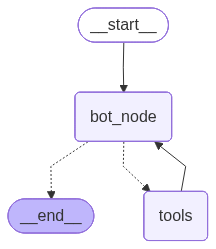

In [ ]:
from langgraph.graph import StateGraph, MessagesState, START

# StateGraph 객체를 생성합니다.
builder = StateGraph(MessagesState)

# bot 노드 정의
def bot_node(state: MessagesState):
    ai_resp = llm_with_tools.invoke(state["messages"]) # llm 이 아니라 llm_with_tools 를 써야 함.
    return {"messages": [ai_resp]}  # 새 응답만 추가

# ToolNode 사용해서 tool_node 생성
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools)

# 그래프 만들기
builder.add_node("bot_node", bot_node)
builder.add_node("tools", tool_node)

builder.add_edge(START, "bot_node")
builder.add_conditional_edges("bot_node", tools_condition)
builder.add_edge("tools", "bot_node")

graph = builder.compile()
graph

4. 실제 요청에 대한 그래프 실행 및 결과 출력

In [ ]:
from langchain_core.messages import HumanMessage

messages = [
    HumanMessage(content="오늘 대전의 날씨를 알려줘.")
]

result = graph.invoke({"messages": messages}) # messages 형태 {"messages": messages}

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

오늘 대전의 날씨를 알려줘.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_XQLGIVNCJdNSvzCePBS2PwDQ)
 Call ID: call_XQLGIVNCJdNSvzCePBS2PwDQ
  Args:
    location: 대전
================================= Tool Message =================================
Name: get_weather

대전의 날씨는 맑습니다.
================================== Ai Message ==================================

오늘 대전의 날씨는 맑습니다.


5. 분기 그래프 생성

In [31]:
# node_1: 고양이가 등장하는 메시지 추가
def node_1(state: MessagesState):
    print("---node_1 노드 실행합니다.---")
    return {"messages": [HumanMessage(content="고양이가")]}

# node_2: 걷는 행동 추가
def node_2(state: MessagesState):
    print("---node_2 노드 실행합니다.---")
    return {"messages": [HumanMessage(content="걸어다닙니다.")]}

# node_3: 뛰는 행동 추가
def node_3(state: MessagesState):
    print("---node_3 노드 실행합니다.---")
    return {"messages": [HumanMessage(content="뛰어다닙니다.")]}

In [ ]:
import random
from typing import Literal

# node_1 다음에 갈 노드를 무작위로 선택
def decide_mood(state) -> Literal["node_2", "node_3"]: #  -> Literal["node_2", "node_3"] 이 부분 꼭 필요
    """
    상태를 기반으로 node_2 또는 node_3 중 하나를 선택합니다.
    현재는 50/50 확률로 무작위로 선택합니다.
    """
    # 50% 확률로 node_2 또는 node_3 반환
    if random.random() < 0.5:
        return "node_2"
    else:
        return "node_3"

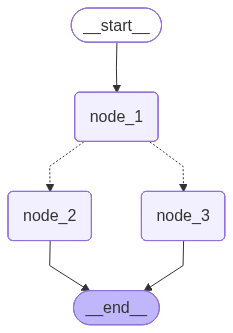

In [35]:
from langgraph.graph import StateGraph, MessagesState, START, END

# 그래프 빌더 생성
builder = StateGraph(MessagesState)

# 노드 추가
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 엣지(연결선) 추가
builder.add_edge(START, "node_1")               # 시작 → node_1
builder.add_conditional_edges("node_1", decide_mood)  # node_1 → 조건에 따라 node_2 or node_3
builder.add_edge("node_2", END)                 # node_2 → 종료
builder.add_edge("node_3", END)                 # node_3 → 종료

graph = builder.compile()
graph

In [48]:
response = graph.invoke({
    "messages": [HumanMessage(content="꽁꽁 얼어붙은 한강 위로")]
})

print(response)

for msg in response['messages']:
    print(msg.content)

---node_1 노드 실행합니다.---
---node_2 노드 실행합니다.---
{'messages': [HumanMessage(content='꽁꽁 얼어붙은 한강 위로', additional_kwargs={}, response_metadata={}, id='be7d48f9-1360-4958-91b5-9bb8f7013dc3'), HumanMessage(content='고양이가', additional_kwargs={}, response_metadata={}, id='454afbed-b993-4396-8211-bf201939d707'), HumanMessage(content='걸어다닙니다.', additional_kwargs={}, response_metadata={}, id='6108a05a-d05b-416d-b441-cd3b59025cca')]}
꽁꽁 얼어붙은 한강 위로
고양이가
걸어다닙니다.
